In [1]:
import os
import copy

In [2]:
import torch
import torch.nn as nn

from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.renderer import RayBundle

/home/jd/anaconda3/envs/3d/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.chdir("..")

In [6]:
%load_ext autoreload
%autoreload 2

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/c/Users/jaide/Desktop/Deep-Learning-for-3D-Data/hw3


In [7]:
from datasets import *

## Setup dataset

In [10]:
from configs import get_cfg_defaults
from cprint import cprint
cfg = get_cfg_defaults()
cprint.info(cfg)

CfgNode({'project_name': 'nerf_dummy', 'experiment_name': '', 'log_dir': '/tmp/nerf/logs', 'weight_dir': './weights', 'log_frequency': 250, 'save_frequency': 1, 'log_model_checkpoint': True, 'script_mode': 'train', 'data_dir': 'data/bottles', 'split_dir': 'splits/bottles', 'width': 100, 'height': 100, 'load_ckpt_path': None, 'model_hparams': CfgNode({'pos_emb_num': 10, 'dir_emb_num': 10, 'hidden_dim': 256}), 'model': 'nerf', 'raysampler': CfgNode({'num_rays': 4000, 'num_pts': 64, 'min_depth': 0.1, 'max_depth': 5.0}), 'num_epochs': 100, 'no_cuda': True, 'batch_size': 1, 'iterations': 20, 'num_workers': 2, 'learning_rate': 0.0001, 'scheduler_step_size': 5000, 'seed': 215})


In [11]:
dm = make_datamodule(cfg)
dm.setup('fit')
dm.setup('test')
cprint.warn(f"Datamodule made")

Datamodule made


In [12]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

In [99]:
# batches = [next(iter(train_dataloader)) for i in range(100)]

it = iter(test_dataloader)
batches = [next(it) for i in range(200)][::10]

# Base

In [100]:
class BaseSampler(nn.Module):

    def __init__(self, 
                img_size: int, 
                n_pts_per_ray: int, 
                min_depth: float, 
                max_depth: float, 
                batch_size: int, 
                device: torch.device,
                K = torch.tensor
                ):
        super().__init__()

        self.img_size = img_size
        self.n_pts_per_ray = n_pts_per_ray
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.batch_size = batch_size
        self.device = device
        self.K = K

        # Create 2D mesh
        range_coord = torch.linspace(0, self.img_size-1, self.img_size, device=self.device)
        i, j = torch.meshgrid(range_coord, range_coord)
        
        i, j = i.T.flatten(), j.T.flatten()
        
        points = torch.stack([i, j], dim=-1).expand((self.batch_size, self.img_size ** 2, 2)).to(device=self.device)
        xys = torch.stack([i, j], dim=-1).expand((self.batch_size, self.img_size ** 2, 2)).to(device=self.device)

        # 2D points -> Homogenous coordinates
        points_homo = torch.cat((points, torch.ones((self.batch_size, self.img_size ** 2, 1), device=self.device)), dim=-1).float()

        # Backproject points
        points_cam = torch.linalg.inv(self.K[:, :3, :3]) @ points_homo.permute(0, 2, 1)
        points_cam[:, 1:, :] *= -1
    
        self.points_cam = points_cam
        self.xys = xys

# Monte-Carlo Raysampler

In [101]:
class MonteCarloRaysampler(BaseSampler):
    
    def __init__(self, 
        img_size: int,
        n_rays_per_image: int,
        n_pts_per_ray: int,
        min_depth: float,
        max_depth: float,
        batch_size: int,
        device: torch.device,
        K: torch.tensor
    ) -> None:
        
        super().__init__(img_size, n_pts_per_ray, min_depth, max_depth, batch_size, device, K)

        self.n_rays_per_image = n_rays_per_image
        
    def forward(self, cameras: CamerasBase):
        
        num_cameras = len(cameras.R)

        rnd_idxs = torch.randperm(self.img_size ** 2, device=self.device)[:self.n_rays_per_image]

        points_cam = self.points_cam.clone()[..., rnd_idxs] # B, 3, N_rays
        points = self.xys[:, rnd_idxs, :].clone() # B, N_rays, 2

        # Set ray origin to translation component of pose
        ray_origins = (cameras.R @ points_cam.clone()).permute(0, 2, 1) + \
            cameras.T.expand((num_cameras, self.n_rays_per_image, 3))
        
        # Rotate ray directions
        ray_directions = (cameras.R @ points_cam).permute(0, 2, 1)
        ray_directions = nn.functional.normalize(ray_directions, dim=-1)

        depths = torch.linspace(self.min_depth, self.max_depth, self.n_pts_per_ray, device=self.device)
        lengths = depths.expand(num_cameras, self.n_rays_per_image, self.n_pts_per_ray)
        
        raybundle = RayBundle(
            origins=ray_origins,
            directions=ray_directions,
            lengths=lengths,
            xys=(points - self.img_size * 0.5) / (self.img_size * 0.5)
        )
        
        return raybundle

In [102]:
raysampler = MonteCarloRaysampler(
    img_size=100, 
    n_rays_per_image=100, 
    n_pts_per_ray=64, 
    min_depth=0.1, 
    max_depth=5,
    batch_size=1,
    device=torch.device('cpu'),
    K=batches[0]['intrinsics'])

# Check rays

In [103]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    EmissionAbsorptionRaymarcher,
    RayBundle,
    ray_bundle_to_ray_points,
)

## Plot

In [104]:
import matplotlib.pyplot as plt
import numpy as np

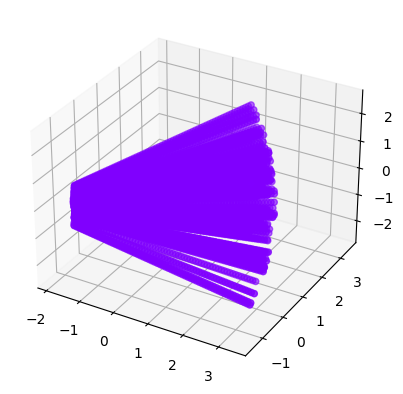

In [105]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for idx, batch in enumerate(batches):
    
    batch = FoVPerspectiveCameras(
        R = batch['R'], 
        T = batch['t'], 
        K = batch['intrinsics'],
    )
    
    rays = raysampler(batch)
    origins = rays.origins.cpu().numpy()[0]
    directions = rays.directions.cpu().numpy()[0]
    xy = rays.xys.cpu().numpy()[0]
    lengths = rays.lengths.cpu().numpy()[0]
    
    assert np.min(xy) >= -1 and np.max(xy) <= 1
    
#     plt.scatter(xy[:, 0], xy[:, 1], s=10)
#     plt.show()
    
#     break

#     print(origins[0])
#     continue
    
    points = []
    for i, (o, d) in enumerate(zip(origins, directions)):
        for j in range(len(lengths[i])):
#             print(lengths[i][j])
            points.append(o + lengths[i][j] * d)
    
    points = np.array(points)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=plt.cm.rainbow(idx / len(batches)))
    break
plt.show()
    
#     plt.scatter(points[:, 0], points[:, 1])
#     plt.show()

Corresponding test path:

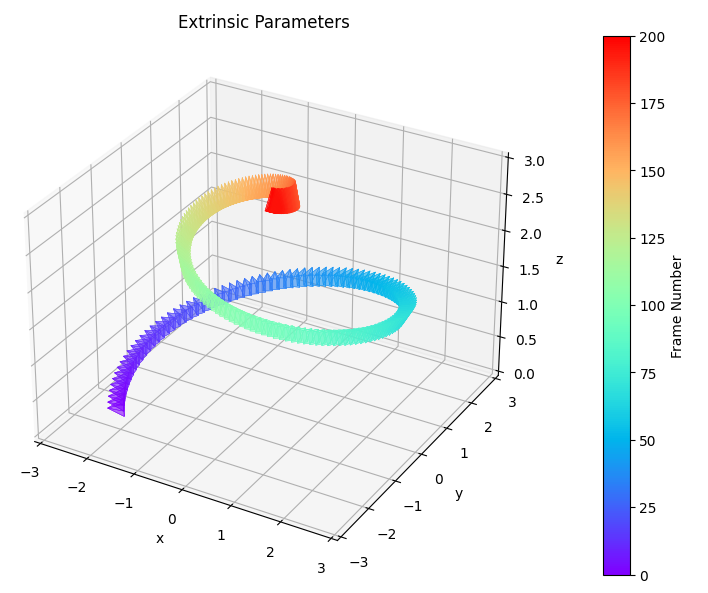

# AllRaysampler

In [106]:
class AllRaySampler(BaseSampler):
    
    def __init__(self, 
        img_size: int,
        n_pts_per_ray: int,
        min_depth: float,
        max_depth: float,
        batch_size: int,
        device: torch.device,
        K: torch.tensor
    ) -> None:
        
        super().__init__(img_size, n_pts_per_ray, min_depth, max_depth, batch_size, device, K)
                
    def forward(self, cameras: CamerasBase) -> RayBundle:

        points_cam = self.points_cam.clone()
        xys = self.xys.clone()

        # Set ray origin to translation component of pose
        ray_origins = (cameras.R @ points_cam.clone()).permute(0, 2, 1) + \
            cameras.T.expand((self.batch_size, self.img_size ** 2, 3))
    
        # Rotate ray directions
        ray_directions = (cameras.R @ points_cam).permute(0, 2, 1)
        ray_directions = nn.functional.normalize(ray_directions, dim=-1)
        
        depths = torch.linspace(self.min_depth, self.max_depth, self.n_pts_per_ray).to(device=self.device)
        lengths = depths.expand(self.batch_size, self.img_size ** 2, self.n_pts_per_ray).to(device=self.device)
        
        raybundle = RayBundle(
            origins=ray_origins,
            directions=ray_directions,
            lengths=lengths,
            xys=(xys - self.img_size * 0.5) / (self.img_size * 0.5)
        )

        return raybundle

In [113]:
raysampler_ndc = AllRaySampler(
    img_size=10, 
    n_pts_per_ray=64, 
    min_depth=0.1, 
    max_depth=5,
    batch_size=1,
    device=torch.device('cpu'),
    K=batches[0]['intrinsics'])

In [114]:
# batch = next(iter(val_dataloader))

In [115]:
# intrinsic_scale = 0.1

# batch['intrinsics'][0, 0, 2] *= intrinsic_scale
# batch['intrinsics'][0, 1, 2] *= intrinsic_scale
# batch['intrinsics'][0, 0, 0] *= intrinsic_scale
# batch['intrinsics'][0, 1, 1] *= intrinsic_scale


# batch_inp = FoVPerspectiveCameras(
#         R = batch['R'], 
#         T = batch['t'], 
#         K = batch['intrinsics'],
#     )

# # raysampler_ndc(batch_inp)

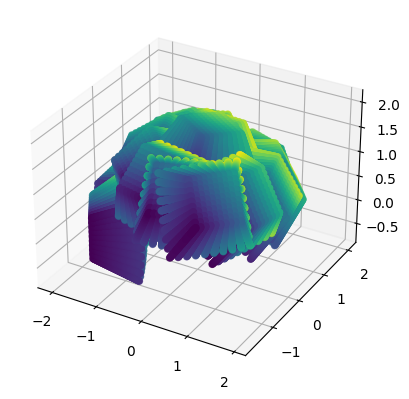

In [118]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for idx, batch in enumerate(batches[:]):
    
    batch = copy.deepcopy(batch)

    intrinsic_scale = 0.1

    batch['intrinsics'][0, 0, 2] *= intrinsic_scale
    batch['intrinsics'][0, 1, 2] *= intrinsic_scale
    batch['intrinsics'][0, 0, 0] *= intrinsic_scale
    batch['intrinsics'][0, 1, 1] *= intrinsic_scale

    batch_cam = FoVPerspectiveCameras(
        R = batch['R'], 
        T = batch['t'], 
        K = batch['intrinsics'],
    )

    raysampler_ndc = AllRaySampler(
        img_size=10, 
        n_pts_per_ray=64, 
        min_depth=0.1, 
        max_depth=5,
        batch_size=1,
        device=torch.device('cpu'),
        K=batch['intrinsics'])

    rays = raysampler_ndc(batch_cam)
    
    origins = rays.origins.cpu().numpy()[0]
    directions = rays.directions.cpu().numpy()[0]
    
#     plt.scatter(xy[:, 0], xy[:, 1])
#     plt.show()

#     print(origins[0])
#     continue
    
    points = []
    for i, (o, d) in enumerate(zip(origins, directions)):
        for j in range(1, 100):
            points.append(o + j/100 * d)
    
    points = np.array(points)

#     xy = rays.xys.cpu()
#     grid = xy.view(1, 100, 100, 2) # B x H x W x 2
#     rgb_points = torch.nn.functional.grid_sample(
#         input=batch['RGB'],
#         grid=grid,
#         mode='bilinear',
#         align_corners=True
#     ).permute(0, 2, 3, 1) # B x H x W x 3
    
    
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(rgb_points[0])
#     ax[1].imshow(batch['RGB'][0].permute(1, 2, 0))
#     plt.show()
    
#     ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=plt.cm.rainbow(idx / len(batches)))
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 1])
#     break
plt.show()
    
#     plt.scatter(points[:, 0], points[:, 1])
#     plt.show()

In [288]:
import copy

In [289]:
for i in range(1, len(batches)):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for idx, batch in enumerate(batches[:i]):

        batch = copy.deepcopy(batch)
        
        intrinsic_scale = 0.1

        batch['intrinsics'][0, 0, 2] *= intrinsic_scale
        batch['intrinsics'][0, 1, 2] *= intrinsic_scale
        batch['intrinsics'][0, 0, 0] *= intrinsic_scale
        batch['intrinsics'][0, 1, 1] *= intrinsic_scale

        batch = FoVPerspectiveCameras(
            R = batch['R'], 
            T = batch['t'], 
            K = batch['intrinsics'],
        )

        rays = raysampler_ndc(batch)

        origins = rays.origins.cpu().numpy()[0]
        directions = rays.directions.cpu().numpy()[0]
        xy = rays.xys.cpu().numpy()[0]

#         plt.scatter(xy[:, 0], xy[:, 1])
#         plt.show()

#         print(origins[0])
#         continue

        points = []
        for i, (o, d) in enumerate(zip(origins, directions)):
            for j in range(1, 100):
                points.append(o + j/100 * d)

        points = np.array(points)
    #     ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=plt.cm.rainbow(idx / len(batches)))
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 1])
#         break
    plt.show()
    
#     plt.scatter(points[:, 0], points[:, 1])
#     plt.show()


KeyboardInterrupt



# Basic Plot of Image, and Rays

In [124]:
batches[0]['intrinsics'].unsqueeze(0).shape

torch.Size([1, 1, 4, 4])

torch.Size([1, 3, 3]) torch.Size([1, 3]) torch.Size([1, 4, 4])


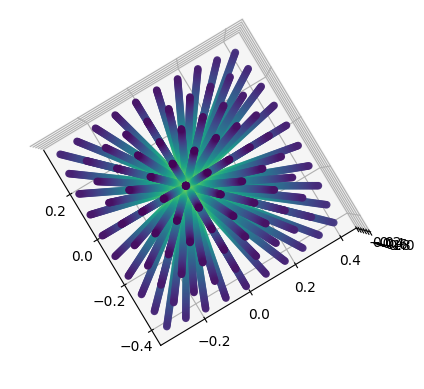

In [170]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

batch = FoVPerspectiveCameras(
    R = torch.eye(3).unsqueeze(0), 
    T = torch.zeros(3).unsqueeze(0), 
    K = copy.deepcopy(batches[0]['intrinsics']),
)

intrinsic_scale = 0.1

batch.K[0, 0, 2] *= intrinsic_scale
batch.K[0, 1, 2] *= intrinsic_scale
batch.K[0, 0, 0] *= intrinsic_scale
batch.K[0, 1, 1] *= intrinsic_scale

print(batch.R.shape, batch.T.shape, batch.K.shape)

rays = raysampler_ndc(batch)

origins = rays.origins.cpu().numpy()[0]
directions = rays.directions.cpu().numpy()[0]
xy = rays.xys.cpu().numpy()[0]

points = []
for i, (o, d) in enumerate(zip(origins, directions)):
    for j in range(1, 100):
        points.append(o + j/100 * d)

points = np.array(points)
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=plt.cm.rainbow(idx / len(batches)))
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2])
ax.view_init(270, 30)
plt.show()